# Analyse de signal

## Contexte

Le projet a pour but de differencier les voitures et les camions a l'aide d'un SVM et de methode d'ensembles

## Import

In [38]:
import pandas as pd
import numpy as np
from pydub import AudioSegment
import pickle
import librosa
import os
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from python_speech_features import mfcc
import scipy.io.wavfile as wav
from sklearn import preprocessing
from features_functions import compute_features
import soundfile as sf
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
df = pd.read_csv("data/training_set.csv", header = None)
df

,0,1,2,3,4
0,2ceUOv8A3FE,20.0,30.0,"Train horn,Train","/m/0284vy3,/m/07jdr"
1,2hcY8kXQj60,30.0,40.0,"Train horn,Train","/m/0284vy3,/m/07jdr"
2,2pt7WZBYeeI,30.0,40.0,"Train horn,Train","/m/0284vy3,/m/07jdr"
3,2wG6EBWr5NQ,30.0,40.0,Train horn,/m/0284vy3
4,2wadsgHvSAM,240.0,250.0,"Train horn,Train","/m/0284vy3,/m/07jdr"
...,...,...,...,...,...
51167,zhlZ7kzqY9w,30.0,40.0,Train,/m/07jdr
51168,zjQsLnmGJn4,60.0,70.0,Train,/m/07jdr
51169,zoeGsPS6ovY,110.0,120.0,Train,/m/07jdr
51170,ztdPIQeG8nw,30.0,40.0,Train,/m/07jdr


In [3]:
df_car = df[df[3]==("Car" or "Cars" )]
df_car

,0,1,2,3,4
11236,-0ZXwR3cPh4,30.0,40.0,Car,/m/0k4j
11237,-0bNnlJmBM0,30.0,40.0,Car,/m/0k4j
11238,-0e6R88diBs,30.0,40.0,Car,/m/0k4j
11239,-0khyUGUoto,30.0,40.0,Car,/m/0k4j
11240,-0pX5r9yfXk,30.0,40.0,Car,/m/0k4j
...,...,...,...,...,...
35542,zzNQ2E2a--M,30.0,40.0,Car,/m/0k4j
35543,zzO1pL0qMqE,10.0,20.0,Car,/m/0k4j
35544,zzT3SE2KB-o,30.0,40.0,Car,/m/0k4j
35545,zzgN5tr3Mjg,30.0,40.0,Car,/m/0k4j


In [4]:
df_train = df[df[3]==("Train" )]
df_train.head(15)

,0,1,2,3,4
49355,-bMji18QqpY,30.0,40.0,Train,/m/07jdr
49356,-bT2mP8t58c,30.0,40.0,Train,/m/07jdr
49357,-dEoF65a3RA,30.0,40.0,Train,/m/07jdr
49358,-dXlbxEkN50,510.0,520.0,Train,/m/07jdr
49359,-ev53QkPvGA,30.0,40.0,Train,/m/07jdr
49360,-g6MQlwytt8,30.0,40.0,Train,/m/07jdr
49361,-h2CCdCkS1I,180.0,190.0,Train,/m/07jdr
49362,-hH8ZYxn7zg,10.0,20.0,Train,/m/07jdr
49363,-kN-hzgUrX0,10.0,20.0,Train,/m/07jdr
49364,-kuDq6KTAAU,270.0,280.0,Train,/m/07jdr


## Initialisation des données

In [5]:
liste_car =['Y-0khyUGUoto_30.000_40.000', 'Y-0pX5r9yfXk_30.000_40.000','Y-1BCDEBjtsk_30.000_40.000','Y-1V2ReGbbtM_7.000_17.000','Y-3yVqL0DWQE_30.000_40.000', 'Y-4YYAqYJPBA_30.000_40.000','Y-9g2nvKqTeE_30.000_40.000', 'Y-22plYEwxQQ_30.000_40.000','Y-104y9LRxT0_30.000_40.000']

liste_truck = ['Y-4LGMEr9FtY_30.000_40.000','Y-5UvXobuBos_30.000_40.000','Y-6juGO8y8es_10.000_20.000','Y-6XGcz56P9s_30.000_40.000','Y-7JyNNTdmiQ_30.000_40.000','Y-7naGvL3yig_30.000_40.000','Y-8jVnlHDsso_30.000_40.000', 'Y-74wyz6FYhg_18.000_28.000','Y-85e6j4Xiq4_30.000_40.000']

liste_train = ["YztdPIQeG8nw_30.000_40.000","YzjQsLnmGJn4_60.000_70.000","Yzul7XTMvmRU_210.000_220.000","YzoeGsPS6ovY_110.000_120.000","Y-bT2mP8t58c_30.000_40.000","Y-dXlbxEkN50_510.000_520.000","Y-h2CCdCkS1I_180.000_190.000","Y-kuDq6KTAAU_270.000_280.000","Y-pNxbOSEBbc_10.000_20.000"]

liste = ['Y-0khyUGUoto_30.000_40.000', 'Y-0pX5r9yfXk_30.000_40.000','Y-1BCDEBjtsk_30.000_40.000','Y-1V2ReGbbtM_7.000_17.000','Y-3yVqL0DWQE_30.000_40.000', 'Y-4YYAqYJPBA_30.000_40.000','Y-9g2nvKqTeE_30.000_40.000', 'Y-22plYEwxQQ_30.000_40.000','Y-104y9LRxT0_30.000_40.000','Y-4LGMEr9FtY_30.000_40.000','Y-5UvXobuBos_30.000_40.000','Y-6juGO8y8es_10.000_20.000','Y-6XGcz56P9s_30.000_40.000','Y-7JyNNTdmiQ_30.000_40.000','Y-7naGvL3yig_30.000_40.000','Y-8jVnlHDsso_30.000_40.000', 'Y-74wyz6FYhg_18.000_28.000','Y-85e6j4Xiq4_30.000_40.000']

liste2 = ['Y-0khyUGUoto_30.000_40.000', 'Y-0pX5r9yfXk_30.000_40.000','Y-1BCDEBjtsk_30.000_40.000','Y-1V2ReGbbtM_7.000_17.000','Y-3yVqL0DWQE_30.000_40.000', 'Y-4YYAqYJPBA_30.000_40.000','Y-9g2nvKqTeE_30.000_40.000', 'Y-22plYEwxQQ_30.000_40.000','Y-104y9LRxT0_30.000_40.000','Y-4LGMEr9FtY_30.000_40.000','Y-5UvXobuBos_30.000_40.000','Y-6juGO8y8es_10.000_20.000','Y-6XGcz56P9s_30.000_40.000','Y-7JyNNTdmiQ_30.000_40.000','Y-7naGvL3yig_30.000_40.000','Y-8jVnlHDsso_30.000_40.000', 'Y-74wyz6FYhg_18.000_28.000','Y-85e6j4Xiq4_30.000_40.000',"YztdPIQeG8nw_30.000_40.000","YzjQsLnmGJn4_60.000_70.000","Yzul7XTMvmRU_210.000_220.000","YzoeGsPS6ovY_110.000_120.000","Y-bT2mP8t58c_30.000_40.000","Y-dXlbxEkN50_510.000_520.000","Y-h2CCdCkS1I_180.000_190.000","Y-kuDq6KTAAU_270.000_280.000","Y-pNxbOSEBbc_10.000_20.000"]

## Creation du fichier contenant les Data

In [6]:
for i in liste:
    # load the audio file
    audio_file = f"data/unbalanced_train_segments_training_set_audio_formatted_and_segmented_downloads/{i}.wav"
    samples, sample_rate = librosa.load(audio_file, sr=None, mono=True)
    
    # Define the length of each segment in samples (200ms = 0.2 seconds)
    segment_length = int(0.2 * sample_rate)
    
    # Define the output directory for the segmented audio files
    output_dir = 'sons'
    
    # Create the output directory if it doesn't already exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    frames = librosa.util.frame(samples, frame_length=segment_length, hop_length=segment_length)
    
    for j, frame in enumerate(frames.T):
        # Construct the output filename
        output_filename = f"{output_dir}/{i}_{j}.wav"
        
        # Write the frame to the output file
        sf.write(output_filename, frame, sample_rate)

## Creation des Algo

In [35]:
# Loop over the signals
learningFeatures = []
for i in liste:
    for j in range(48):
        son_file = f'sons/{i}_{j}.wav'
        sample, sample_rate =  librosa.load(son_file, sr=None, mono=True)
        # Compute the signal in three domains
        sig_sq = sample**2
        sig_t = sample / np.sqrt(sig_sq.sum())
        sig_f = np.absolute(np.fft.fft(sig_t))
        sig_c = np.absolute(np.fft.fft(sig_f))

        # Compute the features and store them
        features_list = []
        N_feat, features_list = compute_features(sig_t, sig_f[:sig_t.shape[0]//2], sig_c[:sig_t.shape[0]//2])
        features_vector = np.array(features_list)[np.newaxis,:]

        # Store the obtained features in a np.arrays
        learningFeatures.append(features_vector)

    
# Store the labels
v = np.zeros(432)
c = np.ones(432)
learningLabels = np.concatenate((v, c))

# Convert the learningFeatures list to a numpy array
learningFeatures = np.asarray(learningFeatures).reshape(864, 71)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(learningFeatures, learningLabels, test_size=0.2, random_state=42)

# Learn the model
model = SVC(C=10, kernel='linear', class_weight=None, probability=False)
scaler = preprocessing.StandardScaler(with_mean=True).fit(np.squeeze(X_train))
learningFeatures_scaled = scaler.transform(np.squeeze(X_train))
model.fit(learningFeatures_scaled, y_train)


# Scale the testing features using the scaler trained on the training data
X_test_scaled = scaler.transform(X_test)

# Predict the labels for the testing set
y_pred = model.predict(X_test_scaled)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90        83
         1.0       0.91      0.91      0.91        90

    accuracy                           0.91       173
   macro avg       0.91      0.91      0.91       173
weighted avg       0.91      0.91      0.91       173



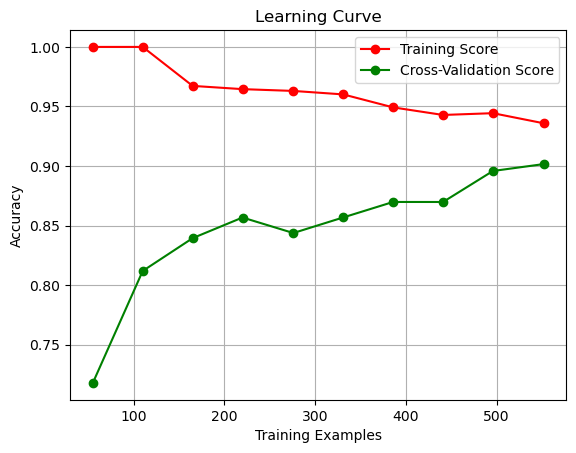

In [31]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                        X=learningFeatures_scaled,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=5,
                                                        scoring='accuracy')

plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.grid()

plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-Validation Score')

plt.legend(loc='best')
plt.show()

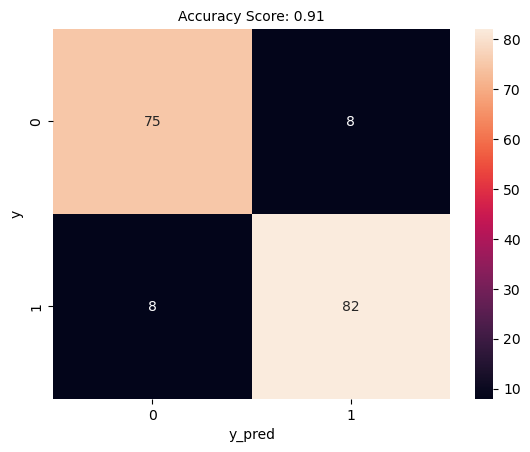

In [39]:
plt.figure()
acc = round(accuracy_score(y_test, y_pred), 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('y_pred')
plt.ylabel('y')
plt.title('Accuracy Score: {0}'.format(acc), size=10)
plt.show()

In [12]:
for i in liste2:
    # load the audio file
    audio_file = f"data/unbalanced_train_segments_training_set_audio_formatted_and_segmented_downloads/{i}.wav"
    samples, sample_rate = librosa.load(audio_file, sr=None, mono=True)
    
    # Define the length of each segment in samples (200ms = 0.2 seconds)
    segment_length = int(0.2 * sample_rate)
    
    # Define the output directory for the segmented audio files
    output_dir = 'sons2'
    
    # Create the output directory if it doesn't already exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    frames = librosa.util.frame(samples, frame_length=segment_length, hop_length=segment_length)
    
    for j, frame in enumerate(frames.T):
        # Construct the output filename
        output_filename = f"{output_dir}/{i}_{j}.wav"
        
        # Write the frame to the output file
        sf.write(output_filename, frame, sample_rate)

In [40]:
# Loop over the signals
learningFeatures2 = []
for i in liste2:
    for j in range(48):
        son_file = f'sons2/{i}_{j}.wav'
        sample, sample_rate =  librosa.load(son_file, sr=None, mono=True)
        # Compute the signal in three domains
        sig_sq = sample**2
        sig_t = sample / np.sqrt(sig_sq.sum())
        sig_f = np.absolute(np.fft.fft(sig_t))
        sig_c = np.absolute(np.fft.fft(sig_f))

        # Compute the features and store them
        features_list = []
        N_feat, features_list = compute_features(sig_t, sig_f[:sig_t.shape[0]//2], sig_c[:sig_t.shape[0]//2])
        features_vector = np.array(features_list)[np.newaxis,:]

        # Store the obtained features in a np.arrays
        learningFeatures2.append(features_vector)

    
# Store the labels
v = np.zeros(432)
c = np.ones(432)
f = np.full((432),2)
learningLabels = np.concatenate((v, c, f))
print(len(learningFeatures2))
# Convert the learningFeatures list to a numpy array
learningFeatures2 = np.asarray(learningFeatures2).reshape(1296, 71)

# Encode the class names
# labelEncoder = preprocessing.LabelEncoder().fit(learningLabels)
# learningLabelsStd = labelEncoder.transform(learningLabels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(learningFeatures2, learningLabels, test_size=0.2, random_state=42)
print(len(X_train),len(X_test),len(y_train),len(y_test))
# Learn the model
model = SVC(C=10, kernel='rbf', class_weight=None, probability=False)
scaler = preprocessing.StandardScaler(with_mean=True).fit(np.squeeze(X_train))
learningFeatures_scaled = scaler.transform(np.squeeze(X_train))
print(len(learningFeatures_scaled))
model.fit(learningFeatures_scaled, y_train)


# Scale the testing features using the scaler trained on the training data
X_test_scaled = scaler.transform(X_test)

# Predict the labels for the testing set
y_pred = model.predict(X_test_scaled)

# Print the classification report
print(classification_report(y_test, y_pred))

1296
1036 260 1036 260
1036
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.92        87
         1.0       0.90      0.89      0.90        91
         2.0       0.95      0.88      0.91        82

    accuracy                           0.91       260
   macro avg       0.91      0.91      0.91       260
weighted avg       0.91      0.91      0.91       260



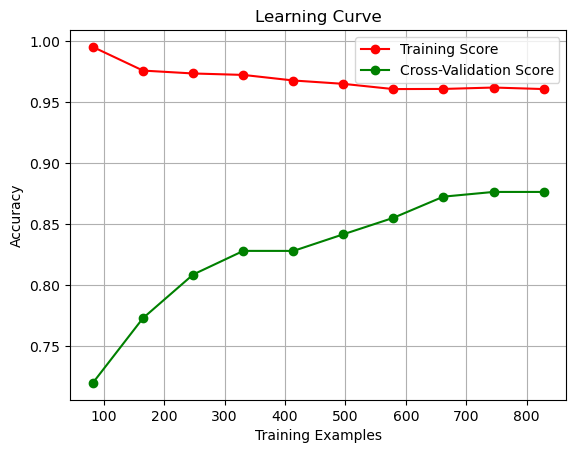

In [33]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                        X=learningFeatures_scaled,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=5,
                                                        scoring='accuracy')

plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.grid()

plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-Validation Score')

plt.legend(loc='best')
plt.show()

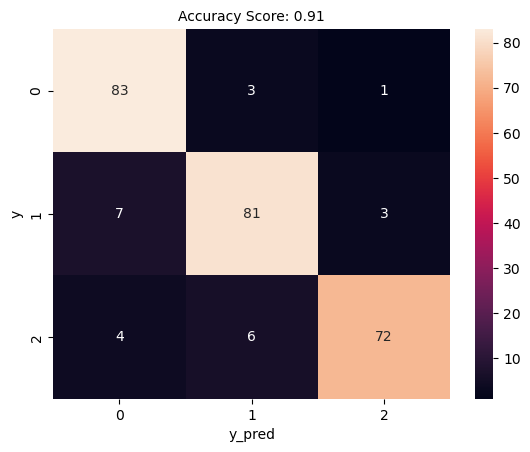

In [41]:
plt.figure()
acc = round(accuracy_score(y_test, y_pred), 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('y_pred')
plt.ylabel('y')
plt.title('Accuracy Score: {0}'.format(acc), size=10)
plt.show()

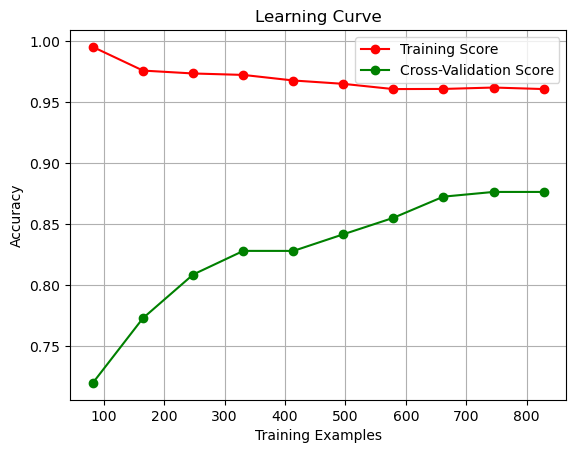

In [27]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                        X=learningFeatures_scaled,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=5,
                                                        scoring='accuracy')

plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.grid()

plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-Validation Score')

plt.legend(loc='best')
plt.show()

In [42]:
import xgboost as xgb

# Initialize the XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic', max_depth=3, learning_rate=0.1, n_estimators=100)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the labels for the testing set
y_pred = model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91        87
         1.0       0.84      0.93      0.89        91
         2.0       0.95      0.85      0.90        82

    accuracy                           0.90       260
   macro avg       0.90      0.89      0.90       260
weighted avg       0.90      0.90      0.90       260



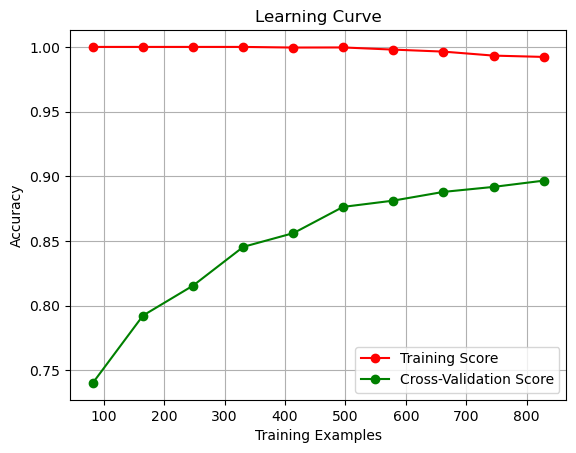

In [29]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                        X=learningFeatures_scaled,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=5,
                                                        scoring='accuracy')

plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.grid()

plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-Validation Score')

plt.legend(loc='best')
plt.show()

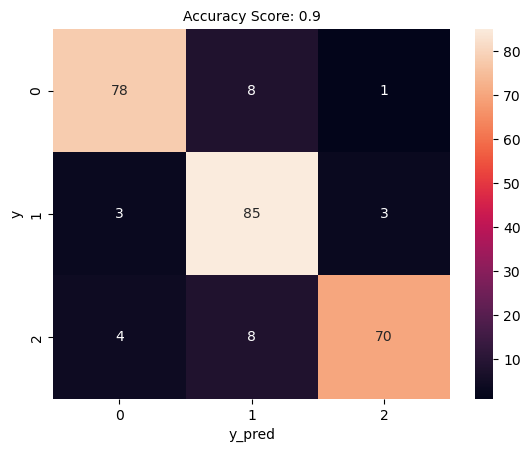

In [43]:
plt.figure()
acc = round(accuracy_score(y_test, y_pred), 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('y_pred')
plt.ylabel('y')
plt.title('Accuracy Score: {0}'.format(acc), size=10)
plt.show()